In [18]:
%env PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

example from https://farside.ph.utexas.edu/teaching/329/lectures/node66.html

In [3]:
x_dom = jnp.linspace(0, 1, 100)[:, None]#[1:-1, None]

default_params = dict(
    alpha_l=array([1.]),
    beta_l=array([-1]),
    gamma_l=array([1.]),
    alpha_h=array([1.]),
    beta_h=array([1.]),
    gamma_h=array([1.]),
)

param_names = list(default_params.keys())

params_space = dict(
    alpha_l=jnp.linspace(0.8, 1, 100)[:, None],
    beta_l=jnp.linspace(-1.0, 0, 100)[:, None],
    gamma_l=jnp.linspace(0.0, 1, 100)[:, None],
    alpha_h=jnp.linspace(0.8, 1, 100)[:, None],
    beta_h=jnp.linspace(0.0, 1, 100)[:, None],
    gamma_h=jnp.linspace(0.0, 1, 100)[:, None],
)


def perm_params(key):
    N = len(params_space)
    keys = random.split(key, N)
    keys = {n:keys[i] for i, n in enumerate(params_space.keys())}
    return tree_map(random.permutation, keys, params_space)


def batch_fun(key):
    batch_size = 10
    batches = len(x_dom) // batch_size
    k1, k2 = random.split(key)

    perms = jax.random.permutation(k1, x_dom.shape[0])
    perms = perms[:batches * batch_size]
    perms = perms.reshape((batches, batch_size))

    params = perm_params(k2)
    
    return x_dom[perms], tree_map(lambda p: p[perms], params)


In [4]:
def plot_sol(u, params):
    x = jnp.linspace(0, 1, 100)
    y_pred = u(x, params)
    y_true = analytic_sol(x, params)
    f = plt.figure(figsize=(5, 2))
    ax = f.subplots(1, 1)
    ax.plot(x, array([y_pred, y_true]).T, label=['y_pred', 'y_true'])
    ax.legend()


def cat_params(**kwargs):
    return concatenate([kwargs[k] for k in param_names if k in kwargs.keys()])

def cat_params_add_default(**kwargs):
    return concatenate([kwargs.get(k, default_params[k]) for k in param_names])

def analytic_sol(x, params):
    alpha_l, beta_l, gamma_l, alpha_h, beta_h, gamma_h = cat_params_add_default(**params)
    a = (alpha_l*alpha_h + alpha_l*beta_h - beta_l*alpha_h)
    b = (gamma_h - (alpha_h + beta_h)/3)
    g = (gamma_l * (alpha_h + beta_h) - beta_l * b) / a
    h = (alpha_l * b - gamma_l * alpha_h) / a
    return g + h * x + x ** 2 / 2 - x**4 / 6


In [169]:
p = init_state.params
sum(tree_leaves(tree_map(lambda p: jnp.prod(array(p.shape)), p)))

DeviceArray(2131, dtype=int64)

In [5]:

key, init_key = random.split(random.PRNGKey(503))
model, params = mlp(init_key, (1 + len(params_space), 30, 30, 30, 1), tanh)

tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=model.apply, 
    params=params,
    tx=tx
)


u = lambda x, params_pde, params_nn: model.apply(params_nn, concatenate([x, cat_params(**params_pde)]))
f = lambda x: 1 - 2 * x ** 2

def loss(params_nn, x, params_pde):
    l_de = vmap(
        lambda x, params_pde, params_nn: (laplace(u)(x, params_pde, params_nn) - f(x)) ** 2,
        (0, 0, None)
    )
    def bnd_l(params_nn, params_pde):
        params = cat_params_add_default(**params_pde)
        alpha, beta, gamma = params[0], params[1], params[2]
        xl = array([0.])
        return alpha * u(xl, params_pde, params_nn) + beta * grad(u)(xl, params_pde, params_nn) - gamma

    def bnd_h(params_nn, params_pde):
        params = cat_params_add_default(**params_pde)
        alpha, beta, gamma = params[3], params[4], params[5]
        xh = array([1.])
        return alpha * u(xh, params_pde, params_nn) + beta * grad(u)(xh, params_pde, params_nn) - gamma

    ll = vmap(
        lambda x, params_pde, params_nn: bnd_l(params_nn, params_pde) ** 2,
        (0, 0, None)
    )
    lh = vmap(
        lambda x, params_pde, params_nn: bnd_h(params_nn, params_pde) ** 2,
        (0, 0, None)
    )

    _l_de = mean(l_de(x, params_pde, params_nn))
    _ll = mean(ll(x, params_pde, params_nn))
    _lh = mean(lh(x, params_pde, params_nn))
    l = _l_de + _ll + _lh
    return l, {"de": _l_de, 'll': _ll, 'lh': _lh, 'total_loss': l}


In [6]:


# def stop(epoch, hist):
#     # #hist = tree_map(lambda a: a[:epoch], hist)
#     # x = hist['total_loss']
#     # print(x.shape)
#     # y = lax.dynamic_slice(x, (-epoch,), (10,))
#     # print(y)
#     # #x = x[i]
#     return hist['total_loss'][epoch] < 0.5e-3


key, train_key = random.split(key)
state, metrics = train_nn(loss, init_state, batch_fun, train_key, epochs=4000)#, stop_condition=stop)

In [160]:
u_nn = lambda x, p: vmap(u, (0, None, None))(
    x[:, jnp.newaxis], 
    p,# tree_map(lambda p: p[:, jnp.newaxis], p), 
    state.params)
# plot_sol(u_nn, array([1, 0.1, 1, 1, 0.1, 1.]))


params = dict(
    alpha_l=array([1.]),
    beta_l=array([-1]),
    gamma_l=array([1.]),
    alpha_h=array([1.]),
    beta_h=array([1.]),
    gamma_h=array([1.]),
)


plot_sol(u_nn, params)

#plot_sol(u_nn, perm_params(subkey)[5])


TypeError: plot_sol() missing 1 required positional argument: 'ax'

In [8]:
key, subkey = random.split(key)
rand_params = perm_params(subkey)
rand_params = tree_map(lambda p: p[4:5], rand_params)
loss(state.params, x_dom[4:5], rand_params)

(DeviceArray(7.19366172e-05, dtype=float64),
 {'de': DeviceArray(6.39239603e-05, dtype=float64),
  'll': DeviceArray(6.88996896e-06, dtype=float64),
  'lh': DeviceArray(1.12268803e-06, dtype=float64),
  'total_loss': DeviceArray(7.19366172e-05, dtype=float64)})

$$ \begin{aligned}\alpha_l&=0.92 \ \\ \beta_l&=-0.64 \ \\ \gamma_l&=0.26 \ \\ \alpha_h&=0.91 \ \\ \beta_h&=0.04 \ \\ \gamma_h&=0.52 \ \end{aligned}$$
$$ \begin{aligned}\alpha_l&=0.95 \ \\ \beta_l&=-0.11 \ \\ \gamma_l&=0.91 \ \\ \alpha_h&=0.98 \ \\ \beta_h&=0.44 \ \\ \gamma_h&=0.17 \ \end{aligned}$$
$$ \begin{aligned}\alpha_l&=0.88 \ \\ \beta_l&=-0.43 \ \\ \gamma_l&=0.24 \ \\ \alpha_h&=0.94 \ \\ \beta_h&=0.46 \ \\ \gamma_h&=0.14 \ \end{aligned}$$
$$ \begin{aligned}\alpha_l&=0.81 \ \\ \beta_l&=-0.77 \ \\ \gamma_l&=0.58 \ \\ \alpha_h&=0.81 \ \\ \beta_h&=0.82 \ \\ \gamma_h&=0.93 \ \end{aligned}$$


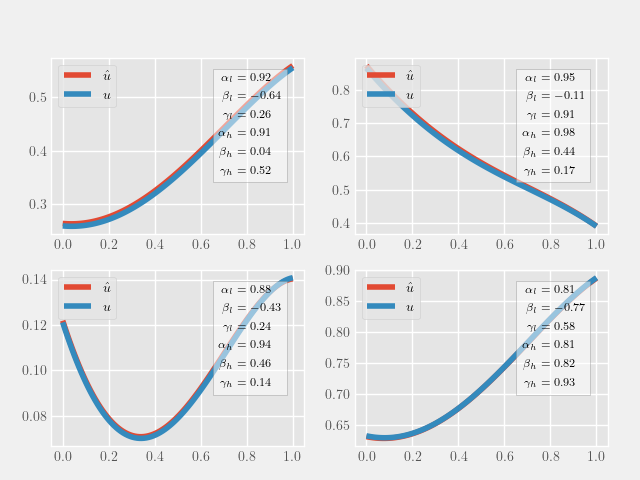

In [95]:
key, subkey = random.split(random.PRNGKey(3))
rand_params = perm_params(subkey)
# rand_params = tree_map(lambda p: p[0], rand_params)
#plot_sol(u_nn, rand_params)
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
from matplotlib import style

plt.style.use("ggplot")

def format_params(params):
    names = {
        'alpha_l': r'\alpha_l',
        'beta_l': r'\beta_l',
        'gamma_l': r'\gamma_l',
        'alpha_h': r'\alpha_h',
        'beta_h': r'\beta_h',
        'gamma_h': r'\gamma_h',
    }
    text = [f"{names[n]}&={float(params[n]):.2} \\" for n in param_names]
    text = r" \\ ".join(text)
    text = r"$$ \begin{aligned}" + text + r" \end{aligned}$$"
    return text

def plot_sol(u, params, ax):
    x = jnp.linspace(0, 1, 100)
    y_pred = u(x, params)
    y_true = analytic_sol(x, params)
    ax.plot(x, array([y_pred, y_true]).T, label=[r'$\hat u$', '$u$'])

    ax.legend(loc="upper left")
    text = format_params(params)
    props = dict(facecolor='white', alpha=0.5, edgecolor="grey")
    ax.text(0.66, 0.6, text, fontsize='small', transform=ax.transAxes, bbox=props)

f = plt.figure()
[[ax1, ax2], [ax3, ax4]] = f.subplots(2, 2)

plot_sol(u_nn, tree_map(lambda p: p[0], rand_params), ax1)
plot_sol(u_nn, tree_map(lambda p: p[1], rand_params), ax2)
plot_sol(u_nn, tree_map(lambda p: p[2], rand_params), ax3)
plot_sol(u_nn, tree_map(lambda p: p[3], rand_params), ax4)

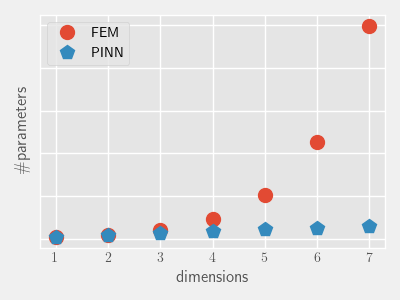

In [159]:
plt.style.use("ggplot")
f = plt.figure(figsize=(4, 3))

ax = f.subplots(1,1)
c = 2.2

x = jnp.linspace(1, 7, 7)
ax.plot(x, c ** x, "o", linewidth=10, markersize=10, label="FEM")
ax.plot(x, c * x, "p", linewidth=10, markersize=10, label="PINN")
ax.legend()
ax.set_xlabel("dimensions")
ax.set_ylabel("\#parameters")
ax.yaxis.set_ticklabels([])
f.tight_layout()


In [ ]:
perm_params(subkey)

{'alpha_l': DeviceArray([[0.86868687],
              [0.82424242],
              [0.88080808],
              [0.87676768],
              [0.83838384],
              [0.81212121],
              [0.94141414],
              [0.81414141],
              [0.94747475],
              [0.85858586],
              [0.8989899 ],
              [0.8020202 ],
              [0.87272727],
              [0.93939394],
              [0.82020202],
              [0.84444444],
              [0.86060606],
              [0.96363636],
              [0.86464646],
              [0.86666667],
              [0.89090909],
              [0.88888889],
              [0.83030303],
              [0.92323232],
              [0.82222222],
              [0.98181818],
              [0.83434343],
              [0.9030303 ],
              [0.95151515],
              [0.89494949],
              [0.83232323],
              [0.98383838],
              [0.88282828],
              [0.81010101],
              [0.88484848],
         

In [157]:
def err(model, params):
    x = jnp.linspace(0, 1, 100)
    def _err(p):
        y_true = analytic_sol(x, p)
        y_pred = model(x, p)
        return mean(abs(y_true - y_pred))
    return mean(vmap(_err)(params))

key, subkey = random.split(key)
u_nn = lambda x, p: vmap(u, (0, None, None))(x[:, jnp.newaxis], p, state.params)

err(u_nn, perm_params(subkey))

DeviceArray(0.01906495, dtype=float64)

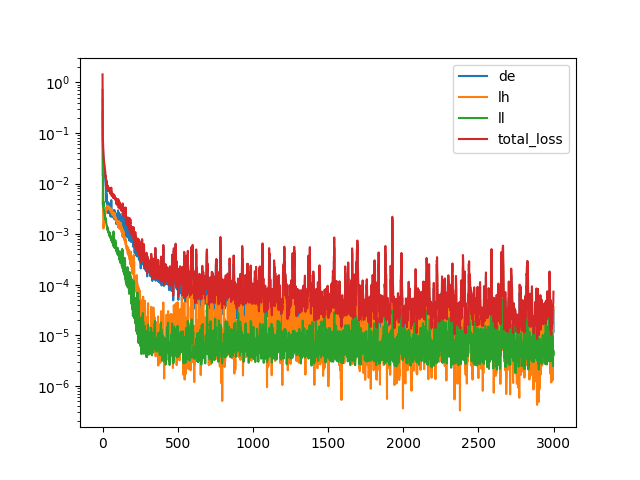

In [88]:
def plot_hist(hist):
    ax = plt.figure().subplots(1, 1)
    for name, h in hist.items():
        ax.plot(h, label=name)
    ax.legend()

plot_hist(metrics)
ax = plt.gca()
ax.set_yscale('log')